<a href="https://colab.research.google.com/github/Dabin-Park/Handson/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_3%EB%8B%A8%EC%9B%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**3장 : 분류**


# MNIST

In [ ]:
#MNIST 데이터셋 다운
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)    # 사이킷런에서 읽어 들인 데이터셋은 일반적으로 딕셔너리 구조를 가진다.
                                                                # as_frame = True : 데이터 프레임으로 만들어 준다.
print(f"mnist.keys : {mnist.keys()}")

mnist.keys : dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])




*   데이터셋 설명하는  DESCR 키
*   샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
*   레이블 배열을 담은 target 키


In [ ]:
print(mnist["DESCR"]) 

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [ ]:
X, y = mnist["data"], mnist["target"]
print(f"X.shape : {X.shape}") # 이미지가 28x28 픽셀이기 때문에 784개의 특성이 있다.
               # 특성 : 0(흰색)부터 255(검은색)까지의 픽셀 강도 
print(f"y.shape : {y.shape}")

X.shape : (70000, 784)
y.shape : (70000,)


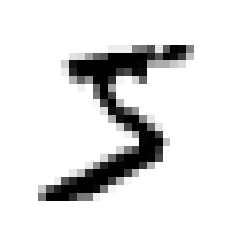

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]   # 첫샘플의 특성 벡터 추출
some_digit_image = some_digit.reshape(28,28)   # 28x28 배열로 크기 변경
plt.imshow(some_digit_image, cmap=mpl.cm.binary)    # cmap : color map 
plt.axis("off")
plt.show()



대부분의 머신러닝 알고리즘은 숫자를 기대 하기 때문에 문자열인 레이블을 정수로 변환



In [ ]:
print(f"y[0] : {y[0]}")    # 첫샘플의 레이블
print(f"type(y[0]) : {type(y[0])}")

y[0] : 5
type(y[0]) : <class 'str'>


In [ ]:
import numpy as np
y = y.astype(np.uint8) 
print(y[0])
print(f"type(y[0]) : {type(y[0])}")

5
type(y[0]) : <class 'numpy.uint8'>


In [ ]:
# 데이터를 넣으면 이미지를 출력하는 함수
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

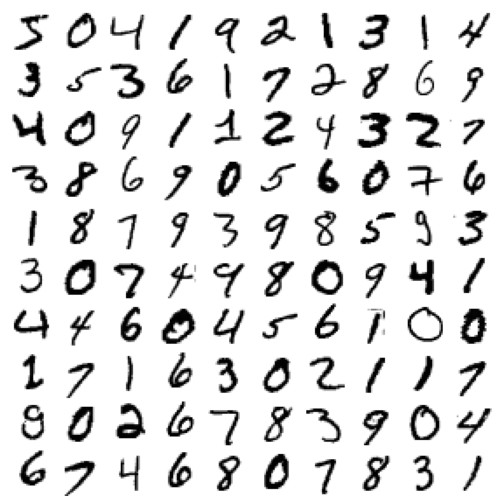

In [ ]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

**데이터를 자세히 조사하기 전에 항상 테스트 세트를 만들고 따로 떼어놓아야 한다.** 
> * MNIST 데이터 셋은 이미 훈련 세트(앞에서 60,000개 이미지)와 테스트세트(나머지 10,000개 이미지)로 나눠둠

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 이진 분류기 훈련

우선 문제의 단순화를 위해 이진 분류기를 만들어 본다 
> 지금은 숫자 5를 식별하는 이진 분류기를 만들어 본다.

In [ ]:
y_train_5 = (y_train == 5)  # 5는 True고, 나머지는 False
y_test_5 = (y_test == 5)

**노트**: `max_iter`와 `tol` 같은 일부 매개변수는 사이킷런 다음 버전에서 기본값이 바뀝니다. 버전이 업데이트되더라도 결과가 바뀌지 않도록 아예 나중에 바뀔 기본값을 사용해 명시적으로 지정하겠습니다. 번거로움을 피하기 위해 책에는 따로 표시하지 않았습니다.

###**사이킷런의 확률적 경사 하강법(SGD)분류기를 사용해볼것이다.**
> * 매우 큰 데이터셋을 효율적으로 처리하는 장점이 있다. (한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문)   
> * SGD는 온라인 학습에 잘 들어 맞는다.


In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

# 성능 측정

## 교차 검증을 사용한 정확도 측정

가끔 사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어 해야 하는 경우가 있다.
> 이때는 교차 검증 기능을 직접 구현하면 된다.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# shuffle=False가 기본값이기 때문에 random_state를 삭제하던지 shuffle=True로 지정하라는 경고가 발생합니다.
# 0.24버전부터는 에러가 발생할 예정이므로 향후 버전을 위해 shuffle=True을 지정합니다.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


cross_val_score() 함수로 폴드가  3개인 k-겹 교차 검증을 사용해 SGD 모델을 평가

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## 오차 행렬
> 아이디어 : 클래스 A의 샘플이 클래스 B로 불류된 횟수를 세는것
>> e.x) 숫자 5의 이미지를 3으로 잘못 불류한 횟수를 알고 싶다면 오차 행렬의 5행 3열을 보면 된다.

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # cross_val_score()함수 처럼 cross_val_predict() 함수도 k-겹 교차 검증을 수행하지만 평가 점수를 반환하는 것이 아닌 각 테스트 폴드에서 얻은 예측을 반환

confusion_matrix() 함수를 사용해 오차 행렬을 만듬 
> 이때 
* y_train_5 : 타깃 클래스
* y_train_pred : 예측 클래스
* 행 : 실제 클래스
* 열 : 예측한 클래스 

첫번째 행
* '5 아님' 이미지(음성 클래스)에 대한것으로, 53892개를 정확하게 분류 했고(진짜 음성) 
* 나머지 687개는 '5'라고 잘못 분류했다(거짓 양성).

두번째 행
* '5' 이미지(양성 클래스)에 대한것으로, 1891개를  '5 아님'으로 잘못 분류했고(거짓 음성)) 
* 나머지 3530개를 정확히 '5'라고 분류 했다(진짜 양성)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)  

array([[53892,   687],
       [ 1891,  3530]])

완벽한 분류기일 경우 주대각선(왼쪽 위에서 오른쪽 아래로)만 0이 아닌 값이 된다.

In [ ]:
y_train_perfect_predictions = y_train_5  # 완벽한 분류기일 경우 
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## 정밀도와 재현율

* TP : 진짜 양성 
* FP : 거짓 음성 
* TN : 진짜 음성 
* FN : 거짓 음성 

정밀도 
> TP/(TP + FP)

재현율
> TP/(TP + FN)

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)    # 정밀도

0.8370879772350012

In [ ]:
cm = confusion_matrix(y_train_5, y_train_pred)  
cm[1, 1] / (cm[0, 1] + cm[1, 1])    # c[1,1] : TP
                                    # c[0,1] : FP

0.8370879772350012

In [ ]:
recall_score(y_train_5, y_train_pred)   # 정밀도 

0.6511713705958311

In [ ]:
cm[1, 1] / (cm[1, 0] + cm[1, 1])    # c[1,1] : TP
                                    # c[1,0] : FN

0.6511713705958311

F_1점수 : 정밀도와 재현율의 조화 평균
> F_1 = 2/(1/정밀도 + 1/재현율) = TP/(TP + (FN+FP)/2)

* 정밀도와 재현율이 비슷한 분류기에서는 F_1 점수가 높다 
> 하지만 이게 항상 바람직한 것은 아니다 
> * 상황에 따라 정밀도가 중요할 수도 있고 재현율이 중요할 수도 있어서


In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [ ]:
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)   # c[1,1] : TP
                                                    # c[0,1] : FP
                                                    # c[1,0] : FN

0.7325171197343847

## 정밀도/재현율 트레이드오프
> 정밀도와 재현율 둘다 높으면 좋겠으나
>* 정밀도를 올리면 재현율이 준다.
>*그 반대도 마찬가지이다.

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])  # decision_function() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있다.
y_scores

array([2164.22030239])

SGD의 임곗값의 기본값은 0
* 따라서 아래의 결과는 True

In [ ]:
threshold = 0   
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ True]


임계값을 8000으로 올리면 
* 결과가 False가 나온다 
> 임곗값을 높이면 재현율이 줄어든다는걸 보여준다. 

In [ ]:
threshold = 8000    
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

##적절한 임곗값을 정하는 방법
>1. cross_val_predict() 함수를 사용해 훈련세트에 있는 모든 샘플의 점수를 구한다.   
(예측 결과가 아닌 결정 점수를 반환하도록 지정) 
2. 1번에서 구한 점수로 precision_recall_curve() 함수를 사용 하여 가능한 모든 임곗값에 대한 정밀도와 재현율을 계산 한다.
3. 맷플롯립을 이용하여 임곗값의 함수로 정밀도와 재현율을 그린다.




In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

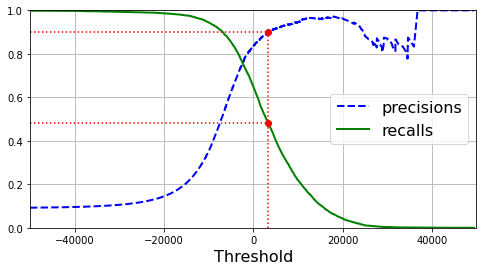

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precisions", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="recalls", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                             
    plt.axis([-50000, 50000, 0, 1])             



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             
plt.show()

In [ ]:
(y_train_pred == (y_scores > 0)).all()

True

## 좋은 정밀도/재현율 트래이드오프를 선택하는 방법
> * 재현율에 재한 정밀도 곡선을 그리는것 
>> * 재현율 80% 근처에서 정밀도가 급격하게 줄어 들기 시작한다.
>> * 이 하강전 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋다.

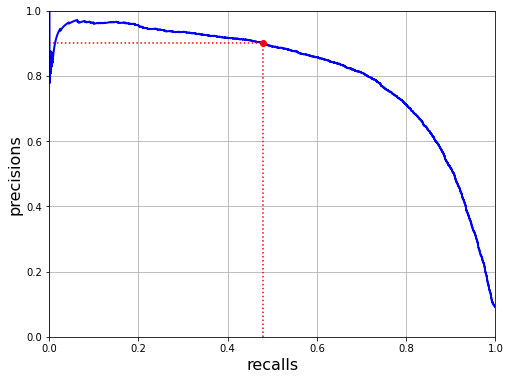

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("recalls", fontsize=16)
    plt.ylabel("precisions", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

정밀도 90%를 달성 하는것이 목표라고 가정
> * 아래 결과가 정밀도가 최소한 90%가 되게 하는 가장 낮은 임계값을 뜻한다.

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

3370.0194991439557


(훈련 세트에 대한) 예측을 만드려면 분류기의 predict() 메서드를 호출하는 대신 아래의 코드를 실행한다.

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## ROC 곡선

* 정밀도/재현율 곡선과 매우 비슷 하다.
>* 하지만 ROC 곡선은 정밀도에 대한 재현율 곡선이 아닌 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR)의 곡선이다.
* ROC 곡선도 트레이드오프가 있다.
>* 아래 그래프의 점선은 완전한 랜덤 분류기의 ROC 곡선이다.
>> * 랜덤 분류기는 훈련 데이터의 클래스 비율을 따라 무작위로 예측하는것을 말한다. 
>> * 이렇게 되면 오차 행렬의 실제 클래스가 비슷한 비율의 예측 클래스로 나뉘어 FPR과 TPR 값이 비슷해 진다. 
>> * 결국 ROC 곡선이 y=x에 가깝게 된다. 
>* 따라서 좋은 분류기는 이점선에서 최대한 멀리 떨어져 있는 것이다. (왼쪽 위 모서리)
* 곡선 아래의 면적(AUG)을 측정하면 분류기들을 비교할 수 있다.
>* 완벽한 분류기는 ROC의 AUG가 1이고, 완전한 랜덤 분류기는 0.5이다. 


In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

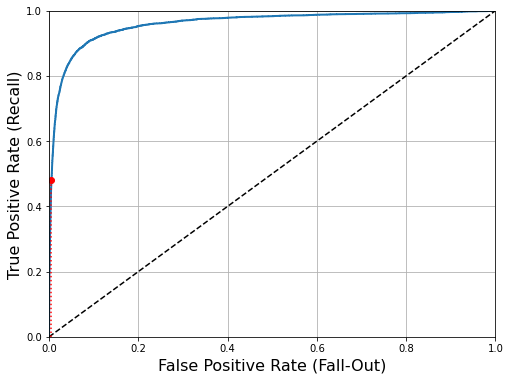

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 대각 점선
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)   
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                   
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:") 
plt.plot([fpr_90], [recall_90_precision], "ro")               
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score   # ROC의 AUG를 계산하는 함수 

roc_auc_score(y_train_5, y_scores)

0.9604938554008616


*  일반적인 법칙은 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 정밀도/재현율 곡선 사용 
* 그런지 않으면  ROC곡선 사용. 

**노트**: 사이킷런 0.22 버전에서 바뀔 기본 값을 사용해 `n_estimators=100`로 지정합니다.

RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC 곡선과 ROC AUG 점수를 비교 해본다.
* RandomForestClassifier에는 decision_function() 메서드가 없기 때문에 predict_proba() 메서드를 사용 한다.
> * 사이킷런 분류기는 일반적으로 이 두 메서드 중 하나 또는 둘 모두를 가지고 있다.
> * predict_proba() 메서드는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환한다.     
( ex. 어떤 이미지가 5일 확률 70%) 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # 점수 = 양성 클래스의 확률
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

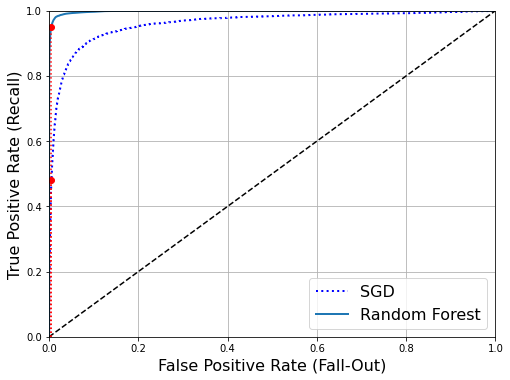

In [ ]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest) # 정밀도

0.9905083315756169

In [ ]:
recall_score(y_train_5, y_train_pred_forest)    # 재현율

0.8662608374838591

# 다중 분류

### 다중 분류기(또는 다항 분류기) 
* 둘 이상의 클래스를 구별할 수 있다.

>여러 개의 클래스를 직접 처리하는 알고리즘 
* SGD 분류기
* 랜덤 포레스트 분류기
* 나이브 베이즈 분류기 등등

> 이진 분류만 가능한 알고리즘 
* 로지스틱 회귀
* 서포트 벡터 머신 분류기 등등




### 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많다.    
 * 예를 들어 특정 숫자 하나만 구분 하는 숫자별 이진 분류기 10개(0에서 부터 9까지)를 훈련 시켜 클래스가 10개인 숫자 이미지 분류 시스템을 만들 수 있다. 
> * 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택하면 된다. 
>> 이를 OvR 전략 이라고 한다. (또는 OvA라고도 부른다)  
> * 또 다른 전략은 0과 1 구별, 0과 2 구별, 1과 2 구별 등과 같이 각 숫자의 조합마다 이진 분류기를 훈련시키는 것이다.
>> 이를 OvO 전략이라고 한다.

> #### OvO 전략
 * 클래스가 N개라면 분류기는 N x (N-1)/2개가 필요하다.
 * MNIST 문제에서는 45개의 분류기를 훈련 시켜야 한다.
 * 이미지 하나를 분류 하려면 45개 분류기를 모두 통과시켜서 가장 많이 양성으로 분류된 클래스를 선택한다. 
 * OvO 전략의 주요 장점은 각 분류기의 훈련에 전체 훈련 세트중 구별할 두 클래스에 해당하는 샘플만 필요하다는 것이다.  


* (서포트 벡터 머신 같은) 일부 알고리즘은 훈련 세트의 크기에 민감해서 큰 훈련 세트에서 몇개의 분류기를 훈련시키는 것보다 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르기 때문에 OvO를 선호 한다. 
* 하지만 대부분의 이진 분류 알고리즘에서는 OvR을 선호한다. 
* 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR또는 OvO를 실행한다. 


In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train_5이 아니라 y_train입니다
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [ ]:
np.argmax(some_digit_scores)

5

In [ ]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
svm_clf.classes_[5]

5

사이킷런에서 OvO나 OvR을 사용 하도록 강제 하려면 OneVsOneClassifier나 OneVsRestClassifier를 사용하면 된다.  

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [ ]:
len(ovr_clf.estimators_)

10

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

**경고**: 사용하는 하드웨어에 따라 다음 두 셀을 실행하는데 30분 또는 그 이상 걸릴 수 있습니다.

분류기 평가에는 일반적으로 교차검증을 사용한다.


In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

입력의 스케일을 조정라면 정확도를 높일 수 있다.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# 에러 분석

### 가능성이 높은 모델을 하나 찾았디고 가정하고 이 모델의 성능을 향상시킬 방법을 찾겠다.
* 한가지 방법은 만들어진 에러의 종류를 분석하는것이다.

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

사이킷런 0.22 버전부터는 `sklearn.metrics.plot_confusion_matrix()` 함수를 사용할 수 있습니다.

In [ ]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

* 이 오차 행렬은 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아 보인다.     
(배열에서 가장 큰값은 흰색, 가장 작은 값은 점은색으로 정규화되어 그려짐)  
>* 숫자 5는 다른 대숫자보다 조금 더 어두워 보인다.   
>> 이유   
>> 1. 데이터셋에 숫자 5의 이미지가 적다.
>> 2. 분류기가 숫자 5를 다른 숫자만큼 잘 분류 하지 못한다. 
> * 두 경우에 대해 모두 확인해봐야 한다. 

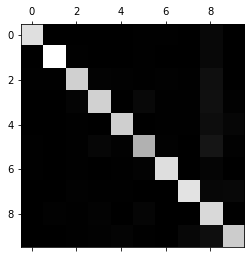

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

오차 행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어(에러의 절대 개수가 아니라) 에러 비율을 비교한다.
* MNIST는 클래스별 이미지 개수가 동일하지 않기 때문에 개수로 비교하면 이미지가 많은 클래스가 상대적으로 나쁘게 보인다.

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

아래의 이미지에서 분류기가 만들 에러르 확실히 볼 수 있다. 
* 행 : 실제 클래스
* 열 : 예측한 클래스 

> * 클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시한다.   
>> 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있다.
> * 하지만 클래스 8의 행은 그리 나쁘지 않다.
>> 이는 실제 8이 적절히 8로 분류되었다는 것을 말해준다.

오차 행렬은 반드시 대칭은 아니다.    
또 3과 5를 많이 혼동 하고 있는 것도 볼 수 있다.

 ### 8로 잘못 분류되는 것을 줄이도록 개선하는 방법 
* 8처럼 보이는(하지만 실제 8은 아닌) 숫자의 훈련 데이터를 더 많이 모아서 실제 8과 구분하도록 분류기를 학습 시킨다.
* 또는 분류기에 도움이 될 만한 특성을 더 찾아 본다.
> * 동심원의 수를 세는 알고리즘(즉, 8은 2개, 6은 1개, 5는 0개)
> * 또는 동심원 같은 어떤 패턴이 드러나도록(Scikit-Image, Pillow, OpenCV 등을 사용해서) 이미지 전처리해볼 수 있다.

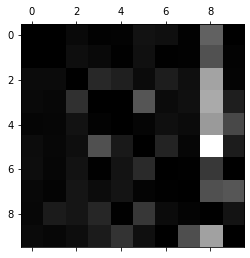

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)   # 주대각선은 0으로 채우기
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

* 왼쪽의 5x5 블록 두개는 3으로 분류된 이미지
* 오른쪽의 5x5 블록 두개는 5로 분류된 이미지

분류기가 분류한 숫자 중 일부(왼쪽 아래 블럭의 1행 2열 데이터)는 정말 잘못 쓰여 있어서 사람도 분류하기 어려울거 같다.    
하지만 대부분의 잘못 분류된 이미지는 확실이 에러인거 같고 분류기가 실수한 이유는 선형 모델인 SGDClassifier를 사용 했기 때문인거 같다. 
* 선형 분류기는 클래스 마다 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산한다. 
* 따라서 3과 5는 몇개의 픽셀만 다르기 때문에 모델이 쉽게 혼동하게 된다.  

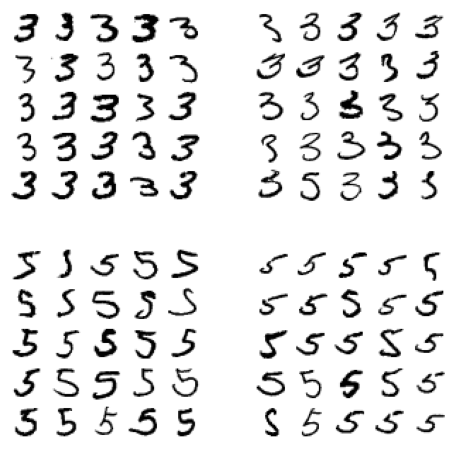

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# 다중 레이블 분류

### 다중 레이블 분류 시스템 
* 여러 개의 이진 꼬리표를 출력하는 분류 시스템

KNeighborsClassifier는 다중 레이블 분류를 지원 하지만 모든 분류기가 그런건 아니다.
* 결정 트리
* 랜덤 포레스트
* OneVsRestClassifier에서도 다중 레이블 분류를 지원한다.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]   # 각 숫자 이미지에 두개의 타깃 레이블이 담긴 배열 (첫 번째는 숫자가 큰 값(7,8,9)인지 나타내고 두 번째는 홀수인지 나타낸다.)을 만듬

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)  # 다중 타킷 배열을 사용해 훈련시킴 

KNeighborsClassifier()

숫자 5를 분류 하였을 때 잘 분류 된다.
* 숫자 5는 크지 않고 : False
* 숫자 5는 홀수 : True


In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

**경고**: 다음 셀은 실행하는데 매우 오래 걸립니다(하드웨어에 따라 몇 시간이 걸릴 수 있습니다).

### 다중 레이블 분류기를 평가하는 방법은 많다.
* 적절한 지표는 프로젝트에 따라 다르다.
> 예를 들어 각 레이블의 F_1 점수를 구하고 (또는 앞서 언급한 어떤 이진 분류 지표를 사용하여) 간단하게 평균 점수를 계산한다. 



아래의 코드는 모든 레이블에 대한 F_1 점수의 평균을 계산
* 실제로는 아닐 수 있지만 아래의 코드는 모든 레이블의 가중치가 같다고 가정한 것이다.

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# 다중 출력 분류

### 다중 출력 다중 클래스 분류 (또는 간단히 다중 출력 분류) 
* 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화 한것이다.
* 즉, 값을 두 개 이상 가질 수 있다.

#### 이미지에서 잡음을 제거하는 시스템 ( 다중 출력 분류 시스템의 예)
* 잡음이 많은 숫자 이미지를 입력 받고 (기대하건대) 깨끗한 숫자 이미지를 MNIST 이미지 처럼 픽셀의 강도를 담은 배열로 출력한다.
* 분류기의 출력이 다중 레이블(픽셀당 한 레이블)이고 각 레이블 값을 여러개 가진다(0 부터 255까지 픽셀 강도) 

randint를 사용해 잡음 추가 

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

테스트 세트에서 이미지를 하나 선택 (여기서 테스트 데이터를 들여다 보는것은 잘못된 것임을 알아야 한다.)

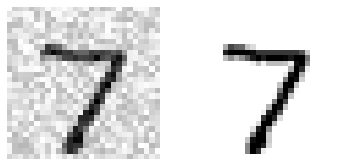

In [ ]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

분류기를 훈련시켜 이 이미지를 깨끗하게 만든다.

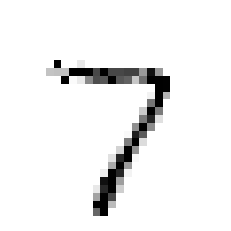

In [ ]:
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)